# Using Information
## Understanding Uncertainty

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Introduction
- Last time, we covered barplot, ECDF, and KDE plots: How to visualize the variability of your data as accumulation or concentration
- This is fundamentally about the relative likelihood of different outcomes, and what values we might predict as likely or unlikely (e.g. median and sample expectation)
- What if, instead, we want to use one variable $X$ to understand the average behavior of a second, $Y$?
- The probabilistic concept we're exploring today is called "Conditioning", as in, "Conditional on $X=x$, we expect $Y$ to behave as..."
- **Conditional Expectation** is the foundation of predictive analytics

# 1. Conditioning on a Categorical Variable

## Categorical on Categorical
- We often want to see how different categorical values determine the proportions of the observations that result in different outcomes
- The main tool for this is **cross tabulation** or a **contingency table**: For each group, count the number of outcomes for each category and compare

## Example: Data Quality and Auditing
- In the Minnesota Police Use of Force data, there are a lot of missing values for `subject_injury`: 9848 missing versus 3077 non-missing
- If the missing values are merely the result of administrative error, they would be **missing at random**: conditioning on various characteristics of the detainee or incident, there shouldn't be systematic patterns in missingness
- Conversely, if data are more likely to be missing in certain situations, we're right to question it; maybe there's a reasonable explanation, but it's worth investigating
- **The fact that data are missing is data itself; that is what we are analyzing**
- Let's cross-tabulate and groupby to see if patterns emerge

In [2]:
df = pd.read_csv('./data/mn_police_use_of_force.csv')
df.head()

,response_datetime,problem,is_911_call,primary_offense,subject_injury,force_type,force_type_action,race,sex,age,type_resistance,precinct,neighborhood
0,2016/01/01 00:47:36,Assault in Progress,Yes,DASLT1,NaN,Bodily Force,Body Weight to Pin,Black,Male,20.0,Tensed,1,Downtown East
1,2016/01/01 02:19:34,Fight,No,DISCON,NaN,Chemical Irritant,Personal Mace,Black,Female,27.0,Verbal Non-Compliance,1,Downtown West
2,2016/01/01 02:19:34,Fight,No,DISCON,NaN,Chemical Irritant,Personal Mace,White,Female,23.0,Verbal Non-Compliance,1,Downtown West
3,2016/01/01 02:28:48,Fight,No,PRIORI,NaN,Chemical Irritant,Crowd Control Mace,Black,Male,20.0,Commission of Crime,1,Downtown West
4,2016/01/01 02:28:48,Fight,No,PRIORI,NaN,Chemical Irritant,Crowd Control Mace,Black,Male,20.0,Commission of Crime,1,Downtown West


In [3]:
# How many missing values are there for subject injury?
df['injury_na'] = df['subject_injury'].isna() # Create a missing value dummy
df['injury_na'].value_counts() # How many missings?

injury_na
True     9848
False    3077
Name: count, dtype: int64

- Let's look at missingness by race:

In [4]:
## Race
df['race'].value_counts()

race
Black                 7648
White                 3129
Native American        784
Other / Mixed Race     205
Asian                  129
Pacific Islander         6
Name: count, dtype: int64

In [5]:
pd.crosstab(df['injury_na'], df['race']) # Raw cross tabulation

race,Asian,Black,Native American,Other / Mixed Race,Pacific Islander,White
injury_na,,,,,,
False,47,1842,220,121,0,771
True,82,5806,564,84,6,2358


- Now, we want to divide each column by the total number of cases within the column, so we can interpret it as a proportion. For example, the proportion of missings for the White group is
$$
\frac{2358}{771+2358} = .7535959
$$
- We write this kind of calculation as a conditional proportion:
$$
\widehat{pr}[ \text{Missing} | \text{White}] = \dfrac{\text{Total number: White and Missing}}{\text{Total number: White}}
$$

- In general, we write these kinds of calculations as
$$
\widehat{pr}[Y=y |X=x] = \dfrac{[\text{Total number: }Y=y \text{ and } X=x]}{[\text{Total number: }X=x]}
$$
- And, more abstractly, as
$$
\widehat{pr}[Y=y |X=x] = \dfrac{\frac{1}{N} \sum_{i=1}^N \mathbb{I}\{y_i=y, x_i=x\}}{\frac{1}{N} \sum_{i=1}^N \mathbb{I}\{x_i=x\}}
$$
- We call this a **conditional proportion**


In [6]:
pd.crosstab(df['injury_na'], df['race'], normalize='columns') # Normalized to proportions

race,Asian,Black,Native American,Other / Mixed Race,Pacific Islander,White
injury_na,,,,,,
False,0.364341,0.240847,0.280612,0.590244,0.0,0.246405
True,0.635659,0.759153,0.719388,0.409756,1.0,0.753595


In [7]:
df.loc[:,['injury_na','race']].groupby('race').mean() # Another way to get the answer

,injury_na
race,
Asian,0.635659
Black,0.759153
Native American,0.719388
Other / Mixed Race,0.409756
Pacific Islander,1.000000
White,0.753595


- Are the conditional proportions systematically different across races?
- How confident are we about these estimates? 

Let's look at sex:

In [8]:
## Sex
df['sex'].value_counts()

sex
Male      10280
Female     2144
Name: count, dtype: int64

In [9]:
pd.crosstab(df['injury_na'], df['sex'])

sex,Female,Male
injury_na,,
False,412,2651
True,1732,7629


In [10]:
pd.crosstab(df['injury_na'],df['sex'],normalize='columns')

sex,Female,Male
injury_na,,
False,0.192164,0.257879
True,0.807836,0.742121


Type of resistance:

In [11]:
## Type of resistance

df['type_resistance'].value_counts()

type_resistance
Tensed                                                                             1748
Tensed                                                                             1230
Other                                                                              1068
Commission of Crime                                                                 949
Fled on Foot                                                                        674
Commission of a Crime                                                               668
Assaulted Officer                                                                   631
Verbal Non-Compliance                                                               587
Verbal Non-Compliance                                                               581
Fled on Foot                                                                        566
Unspecified                                                                         469
Assaulted Office

In [12]:
df['type_resistance'] = df['type_resistance'].fillna('Unspecified')
pd.crosstab( df['type_resistance'],df['injury_na']) # This looks bad

injury_na,False,True
type_resistance,,
Assaulted Officer,399,49
Assaulted Officer,0,631
Assaulted Police Horse,0,2
Assaulted Police K9,0,1
Assaulting Police Horse,5,1
Assaulting Police K9,6,0
COMMISSION OF CRIME,0,1
Commission of Crime,446,503
Commission of a Crime,0,668


In [13]:
df['type_resistance'].unique()

array(['Tensed', 'Verbal Non-Compliance', 'Commission of Crime',
       'Unspecified', 'commission of crime', 'Fled in Vehicle',
       'Assaulted Officer', 'Fled on Foot', 'Assaulting Police K9',
       'verbal non-compliance', 'Assaulting Police Horse', 'tensed',
       'COMMISSION OF CRIME',
       'Verbal Non-Compliance                                                          ',
       'Fled on Foot                                                                   ',
       'Other                                                                          ',
       'Tensed                                                                         ',
       'Commission of a Crime                                                          ',
       'Assaulted Officer                                                              ',
       'Fled in a Vehicle                                                              ',
       'Assaulted Police Horse                                            

In [14]:
pd.crosstab( df['type_resistance'],df['injury_na'],normalize='index')

injury_na,False,True
type_resistance,,
Assaulted Officer,0.890625,0.109375
Assaulted Officer,0.000000,1.000000
Assaulted Police Horse,0.000000,1.000000
Assaulted Police K9,0.000000,1.000000
Assaulting Police Horse,0.833333,0.166667
Assaulting Police K9,1.000000,0.000000
COMMISSION OF CRIME,0.000000,1.000000
Commission of Crime,0.469968,0.530032
Commission of a Crime,0.000000,1.000000


## Exercise 1
- Open the NHANES dataset
- Find two categorical variables of interest (there are 198, and short descriptions are given in the `nhanes_meta_17_18.csv` file). Investigate their missing values (you don't have to focus on missing values for this analysis like we did with police use of force, but always be aware of how dirty the data are)
- Compute a contingency table
- Discuss any interesting patterns (or lack of one) that you observe

## Numeric on Categorical
- When we condition a numeric variable on a categorical one, we can look at **grouped kernel density plots** or **grouped statistics**: For each value of the categorical variable, plot a kernel density or compute the relevant statistics

In [15]:
df = pd.read_csv('./data/ames_prices.csv', low_memory=False)
df['log_price'] = np.log(df['price'])
df.head()

,Order,PID,area,price,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,...,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,log_price
0,1,526301100,1656,215000,20,RL,141.0,31770,Pave,NaN,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,12.278393
1,2,526350040,896,105000,20,RH,80.0,11622,Pave,NaN,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,11.561716
2,3,526351010,1329,172000,20,RL,81.0,14267,Pave,NaN,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,12.055250
3,4,526353030,2110,244000,20,RL,93.0,11160,Pave,NaN,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,12.404924
4,5,527105010,1629,189900,60,RL,74.0,13830,Pave,NaN,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,12.154253


In [16]:
df.columns.to_list()

['Order',
 'PID',
 'area',
 'price',
 'MS.SubClass',
 'MS.Zoning',
 'Lot.Frontage',
 'Lot.Area',
 'Street',
 'Alley',
 'Lot.Shape',
 'Land.Contour',
 'Utilities',
 'Lot.Config',
 'Land.Slope',
 'Neighborhood',
 'Condition.1',
 'Condition.2',
 'Bldg.Type',
 'House.Style',
 'Overall.Qual',
 'Overall.Cond',
 'Year.Built',
 'Year.Remod.Add',
 'Roof.Style',
 'Roof.Matl',
 'Exterior.1st',
 'Exterior.2nd',
 'Mas.Vnr.Type',
 'Mas.Vnr.Area',
 'Exter.Qual',
 'Exter.Cond',
 'Foundation',
 'Bsmt.Qual',
 'Bsmt.Cond',
 'Bsmt.Exposure',
 'BsmtFin.Type.1',
 'BsmtFin.SF.1',
 'BsmtFin.Type.2',
 'BsmtFin.SF.2',
 'Bsmt.Unf.SF',
 'Total.Bsmt.SF',
 'Heating',
 'Heating.QC',
 'Central.Air',
 'Electrical',
 'X1st.Flr.SF',
 'X2nd.Flr.SF',
 'Low.Qual.Fin.SF',
 'Bsmt.Full.Bath',
 'Bsmt.Half.Bath',
 'Full.Bath',
 'Half.Bath',
 'Bedroom.AbvGr',
 'Kitchen.AbvGr',
 'Kitchen.Qual',
 'TotRms.AbvGrd',
 'Functional',
 'Fireplaces',
 'Fireplace.Qu',
 'Garage.Type',
 'Garage.Yr.Blt',
 'Garage.Finish',
 'Garage.Cars',
 'Ga

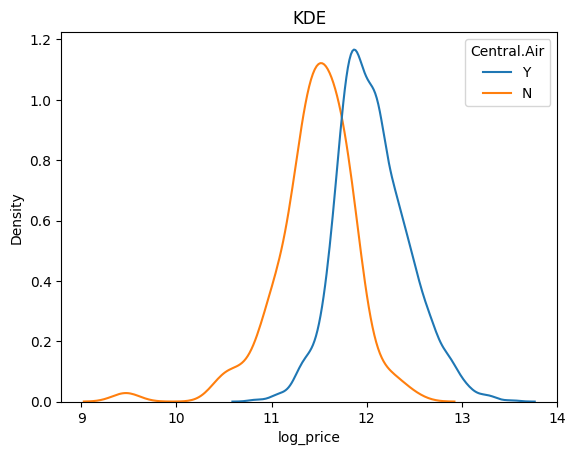

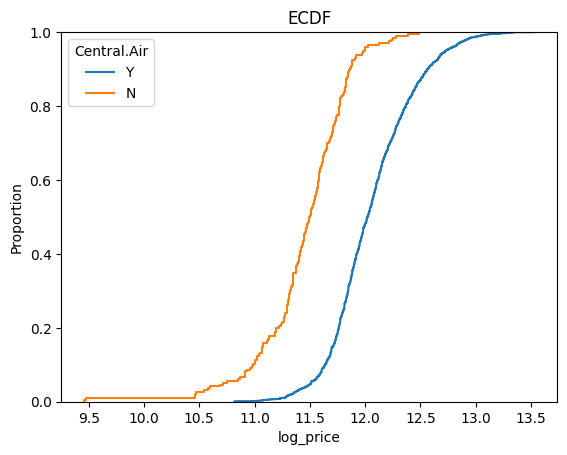

price                                                            \
              count           mean           std      min       25%       50%   
Central.Air                                                                     
N             196.0  101890.479592  37597.024767  12789.0   80000.0   98250.0   
Y            2734.0  186452.787857  79121.363436  50000.0  134500.0  166250.0   

                                 
                  75%       max  
Central.Air                      
N            123250.0  265979.0  
Y            218375.0  755000.0

In [17]:
conditioner = 'Central.Air'
sns.kdeplot( data=df, x='log_price', hue=conditioner, common_norm=False ).set(title='KDE')
plt.show()
sns.ecdfplot( data=df, x='log_price', hue=conditioner).set(title='ECDF')
plt.show()
df.loc[:,['price', conditioner]].groupby(conditioner).describe()

Does Central Air cost $85k, on average?

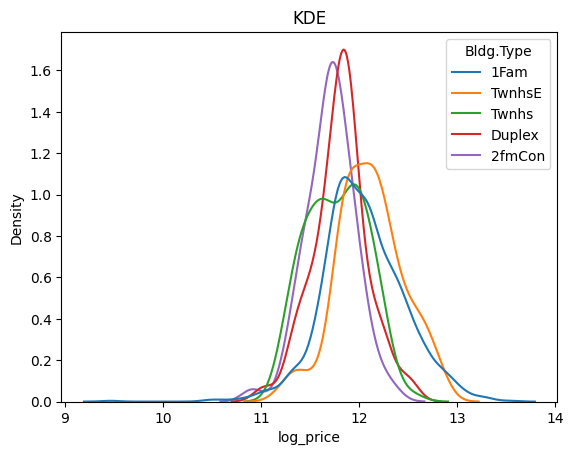

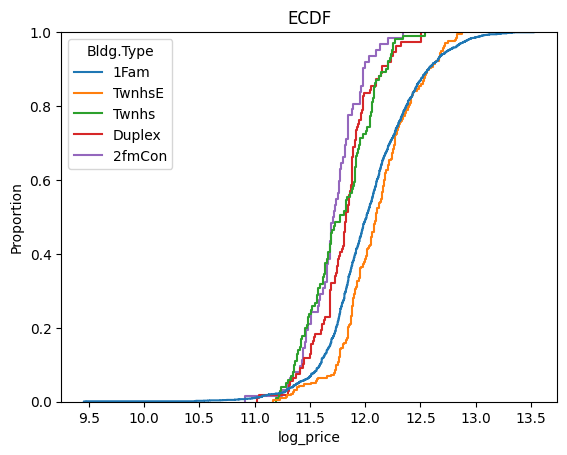

price                                                            \
            count           mean           std      min       25%       50%   
Bldg.Type                                                                     
1Fam       2425.0  184812.041237  82821.802329  12789.0  130000.0  165000.0   
2fmCon       62.0  125581.709677  31089.239840  55000.0  106562.5  122250.0   
Duplex      109.0  139808.935780  39498.973534  61500.0  118858.0  136905.0   
Twnhs       101.0  135934.059406  41938.931130  73000.0  100500.0  130000.0   
TwnhsE      233.0  192311.914163  66191.738021  71000.0  145000.0  180000.0   

                               
                75%       max  
Bldg.Type                      
1Fam       220000.0  755000.0  
2fmCon     140000.0  228950.0  
Duplex     153337.0  269500.0  
Twnhs      170000.0  280750.0  
TwnhsE     222000.0  392500.0

In [18]:
conditioner = 'Bldg.Type'
sns.kdeplot( data=df, x='log_price', hue=conditioner, common_norm=False ).set(title='KDE')
plt.show()
sns.ecdfplot( data=df, x='log_price', hue=conditioner).set(title='ECDF')
plt.show()
df.loc[:,['price', conditioner]].groupby(conditioner).describe()

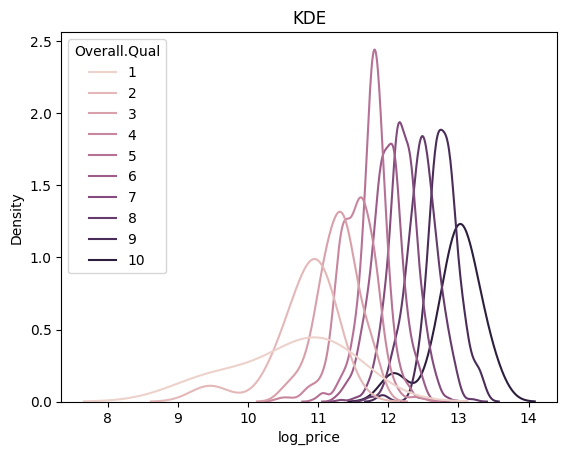

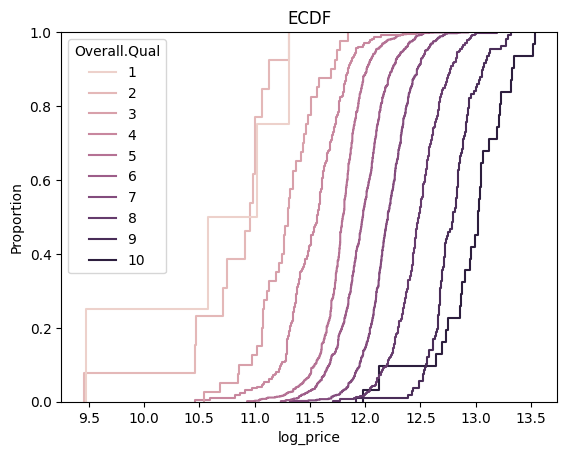

price                                                     \
              count           mean            std       min        25%   
Overall.Qual                                                             
1               4.0   48725.000000   29341.935292   13100.0   32750.00   
2              13.0   52325.307692   17562.955704   12789.0   45000.00   
3              40.0   83185.975000   23569.801683   37900.0   64875.00   
4             226.0  106485.097345   29224.943495   34900.0   85500.00   
5             825.0  134752.516364   27690.596654   55993.0  119600.00   
6             732.0  162130.318306   37201.296411   76000.0  138000.00   
7             602.0  205025.760797   43166.268562   82500.0  176421.25   
8             350.0  270913.594286   61326.207415  122000.0  230000.00   
9             107.0  368336.766355   79201.265422  150000.0  318030.50   
10             31.0  450217.322581  141975.967956  160000.0  385625.00   

                                            
                   50%       75%       max  
Overall.Qual                                
1              50150.0   66125.0   81500.0  
2              57625.0   60000.0   82000.0  
3              81200.0   95475.0  139600.0  
4             105000.0  124275.0  256000.0  
5             133000.0  147983.0  301600.0  
6             159500.0  182000.0  415000.0  
7             200000.0  229600.0  383970.0  
8             264530.5  305975.0  538000.0  
9             360000.0  405374.5  611657.0  
10            451950.0  540112.0  755000.0

In [19]:
conditioner = 'Overall.Qual'
sns.kdeplot( data=df, x='log_price', hue=conditioner, common_norm=False ).set(title='KDE')
plt.show()
sns.ecdfplot( data=df, x='log_price', hue=conditioner).set(title='ECDF')
plt.show()
df.loc[:,['price', conditioner]].groupby(conditioner).describe()

<Axes: xlabel='Overall.Qual'>

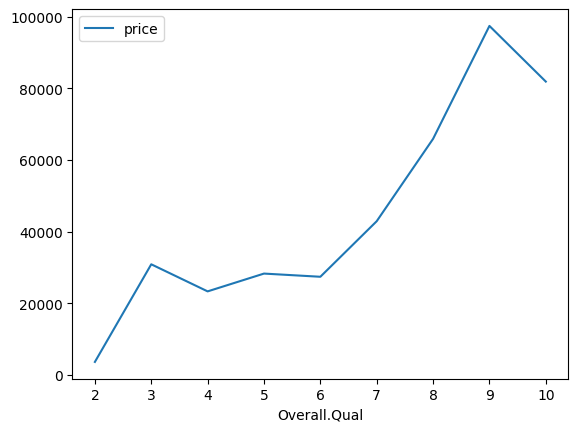

In [20]:
diff = df.loc[:,['price', conditioner]].groupby(conditioner).mean().diff()
sns.lineplot(diff)

## Exercise 2
- Open the NHANES dataset
- Find a categorical and numeric variable of interest (there are 198, and short descriptions are given in the `nhanes_meta_17_18.csv` file). Investigate their missing values (you don't have to focus on missing values for this analysis, but always be aware of them)
- Compute groupby tables and make grouped kernel density plots
- Discuss any interesting patterns (or lack of one) that you observe

# 2. Conditioning on a Numeric Variable

## The Scatter Plot
- When we make a rugplot in two dimensions, it becomes a **scatterplot**
- Just as we used the rugplot to visualize concentration in one dimension, scatterplots give us some sense of "joint mass" in two dimensions
- The big difference is that, in the scatterplot, the human eye relentlessly seeks patterns: As $X$ changes, how does $Y$ tend to change? 
- This $Y|X=x$ style of thinking is the focus today, using a non-parametric approach

In [21]:
df = pd.read_csv('./data/ames_prices.csv', low_memory=False)
df['log_price'] = np.log(df['price'])
df.head()

,Order,PID,area,price,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,...,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,log_price
0,1,526301100,1656,215000,20,RL,141.0,31770,Pave,NaN,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,12.278393
1,2,526350040,896,105000,20,RH,80.0,11622,Pave,NaN,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,11.561716
2,3,526351010,1329,172000,20,RL,81.0,14267,Pave,NaN,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,12.055250
3,4,526353030,2110,244000,20,RL,93.0,11160,Pave,NaN,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,12.404924
4,5,527105010,1629,189900,60,RL,74.0,13830,Pave,NaN,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,12.154253


<Axes: xlabel='area', ylabel='price'>

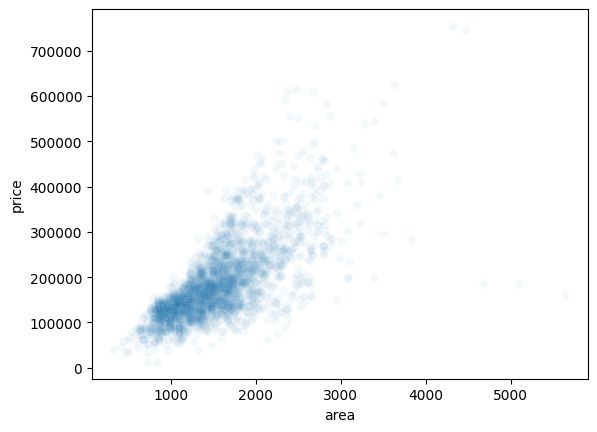

In [22]:
sns.scatterplot(data=df, y='price', x='area',alpha=.05)

<Axes: xlabel='age', ylabel='price'>

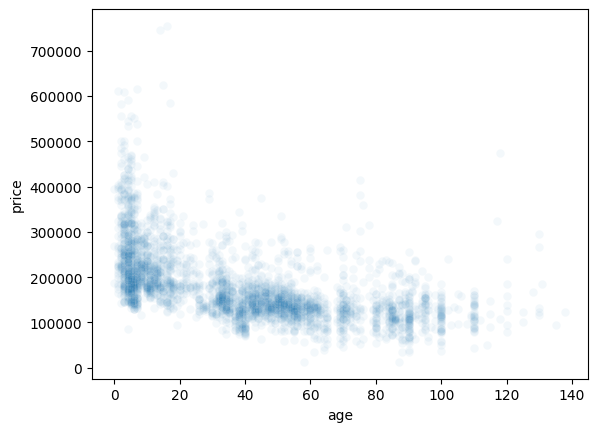

In [23]:
df['age'] = max(df['Year.Built'])-df['Year.Built']

sns.scatterplot(data=df, y='price', x='age',alpha=.05)

## Conditional Expectation
- We can combine a `.groupby` calculation with kernel smoothing to get a good estimate of $Y$ given any particular value of $X=x$. We call this the **Expectation of $Y$, given $X$** or the **Conditional Expectation of $Y$** or $\widehat{\mathbb{E}}[Y|X=x]$, or **CEF**
- Let's start by looking at price conditional on fireplaces; fireplaces is numeric, but... it's essentially an ordered categorical variable

,price
Fireplaces,
0,141195.772152
1,213556.001570
2,242316.162896
3,255820.833333
4,260000.000000


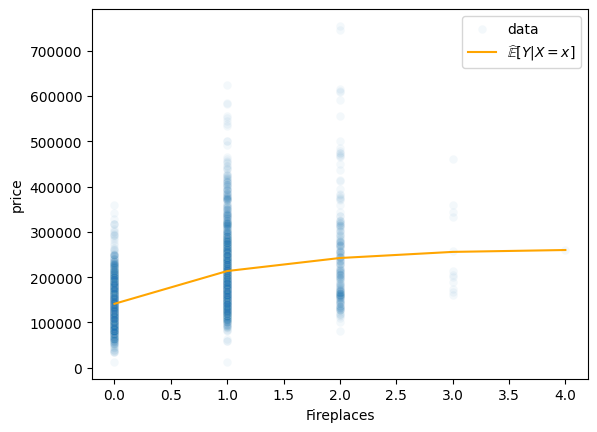

In [24]:
means = df.loc[:,['price','Fireplaces']].groupby('Fireplaces').mean()
sns.scatterplot(data=df, y='price', x='Fireplaces',alpha=.05, label='data')
sns.lineplot(data=means, x='Fireplaces',y='price',color='orange', label='$\\widehat{\\mathbb{E}}[Y|X=x]$')

means

In [25]:
means.diff() # Difference the means to get the changes

,price
Fireplaces,
0,NaN
1,72360.229418
2,28760.161326
3,13504.670437
4,4179.166667


Is the price of installing a first fireplace $72k? A second one $28.7k? A third one $13.5k? A fourth one $4k? Can you raise the value of a house by $100k simply by installing two fireplaces?

## Approximating with Bandwidth
- If the conditioning $X$ isn't discrete, like fireplaces, we need to do something like kernel smoothing
- Let's pick a $(-h,+h]$ window, and compute the conditional average within the window: Divide the observed values of $y$ in that window by the number of $x$'s we observe within that window
- As the window slides from left to right, we get a smooth function that maps $x$ into $\widehat{\mathbb{E}}[Y|X \approx x]$
- This looks a lot like our kernel density estimator?

<Axes: xlabel='age', ylabel='price'>

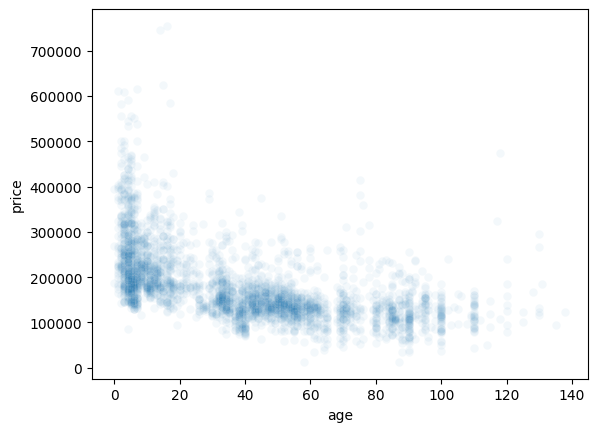

In [26]:
sns.scatterplot(data=df, y='price', x='age',alpha=.05)

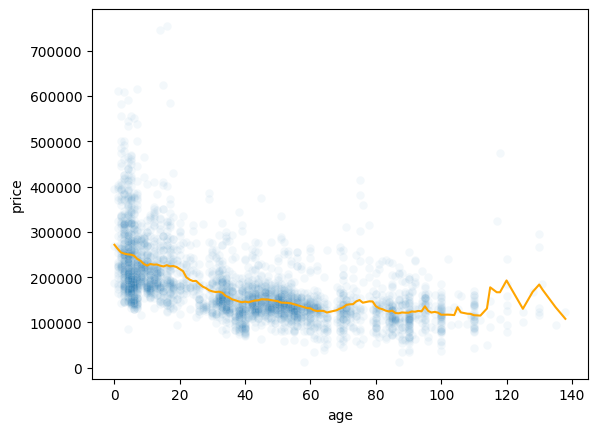

In [27]:
x = df['age']
y = df['price']

def lcls(x,y,h=7, plot=True):
    ''' Computes local constant least squares regression estimates with uniform kernel. '''
    n = len(x) # Number of observations
    grid = np.sort(x.unique()) # Extract and sort unique values for x
    I = np.abs( x.to_numpy().reshape(-1,1)-grid.reshape(1,-1) ) <= h # Compute the kernel
    numerator = y@I/(2*h) # Compute the numerator
    denominator = np.sum(I,axis=0)/(2*h) # Compute denominator
    y_hat = numerator/denominator # Compute estimator

    if plot:
        sns.scatterplot(data=df, y='price', x='age',alpha=.05)
        sns.lineplot(x=grid,y=y_hat, color='orange')

    return y_hat, grid
y_hat, grid = lcls(x,y,h=4)



- Where is our estimator of $\mathbb{E}[Y|X=x]$ reliable? Unreliable?
- What happens if we adjust the bandwidth?

## Back to Smoothing
- When the conditioning variable $X$ is numeric, we can use a sliding window to compute the average within the window
- Let's estimate as
$$
\hat{y}_{N,h}(z) = \dfrac{\frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{2h} \mathbb{I} \{ |x_i - z| \le h \}}{\frac{1}{N} \sum_{i=1}^N \frac{1}{2h} \mathbb{I} \{ |x_i - z| \le h \}}
$$
- In the numerator, we have all the values of $y_i$, weighted by whether their value of $x_i$ appears in the window $z -h \le x_i  \le z + h$
- In the denominator, we rescale by the fraction of the sample in that window: How many "hits" do we get with $x_i$ between $z-h$ and $z+h$?
- Taking the ratio computes a sample average within the window we're interested in, giving us an estimate of the conditional expectation

## Local Constant Least Squares (LCLS) Regression
- Just like with the kernel density estimator, we can replace the uniform kernel with smooth ones, to get a nicer picture
- When we replace the uniform kernel with a general kernel, we get
$$
\hat{y}_{N,h}(z) = \dfrac{\frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left(\frac{z-x_i}{h}\right)}{\frac{1}{N} \sum_{i=1}^N \frac{1}{h}k\left(\frac{z-x_i}{h} \right)}
$$
- This is called **Naradaya-Watson** or **Local Constant Least Squares** (LCLS) regression
- Let's look at an example with a Gaussian Kernel

<Axes: xlabel='area', ylabel='price'>

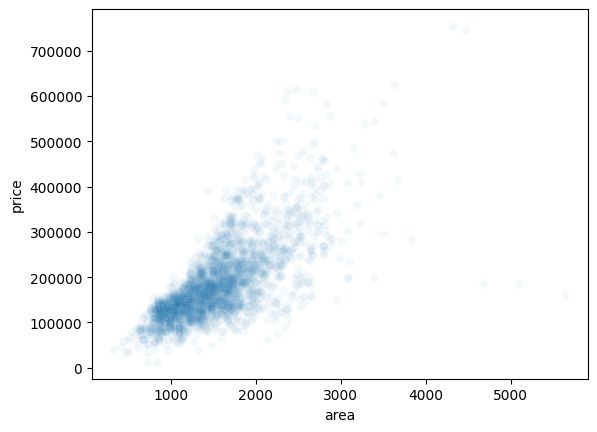

In [28]:
sns.scatterplot(data=df, y='price', x='area',alpha=.05)

Computed bandwidth is: 83.92152075315373


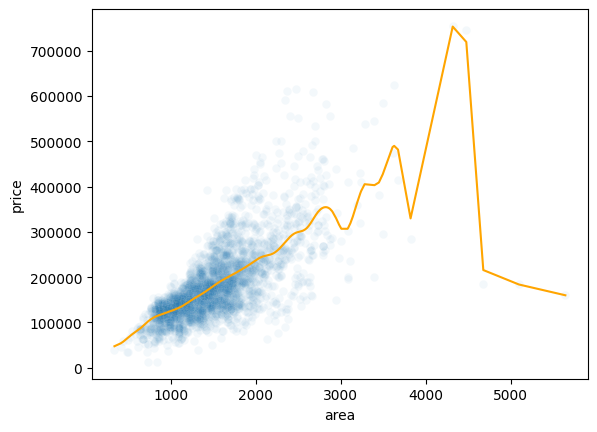

In [29]:
x = df['area']
y = df['price']

def lcls(x,y, h = None, plot=True):
    ''' Computes local constant least squares regression estimates with Gaussian kernel. '''
    
    n = len(x) # Number of observations
    grid = np.sort(x.unique()) # Extract and sort unique values for x

    # Compute bandwidth:
    if h is None:
        iqr = np.quantile(x,.75) - np.quantile(x,.25)
        h = 0.9 * min(np.std(x), iqr/1.34) * len(x) **(-0.2)
        print(f'Computed bandwidth is: {h}')

    # Compute kernel:
    I = -(x.to_numpy().reshape(-1,1)-grid.reshape(1,-1) )**2
    K = np.exp(I/(2*h**2) )/np.sqrt(2*np.pi*h**2 )

    # Compute LCLC estimator:
    numerator = y@K # Compute the numerator
    denominator = np.sum(K,axis=0) # Compute denominator
    y_hat = numerator/denominator # Compute estimator

    # Plot results:
    if plot:
        sns.scatterplot(data=df, y='price', x='area',alpha=.05)
        sns.lineplot(x=grid,y=y_hat, color='orange')

    return y_hat, grid

y_hat, grid = lcls(x,y)

- Where is our estimator of $\mathbb{E}[Y|X=x]$ reliable? Unreliable?
- What happens if we adjust the bandwidth? Does the plug-in value offer a good starting point?

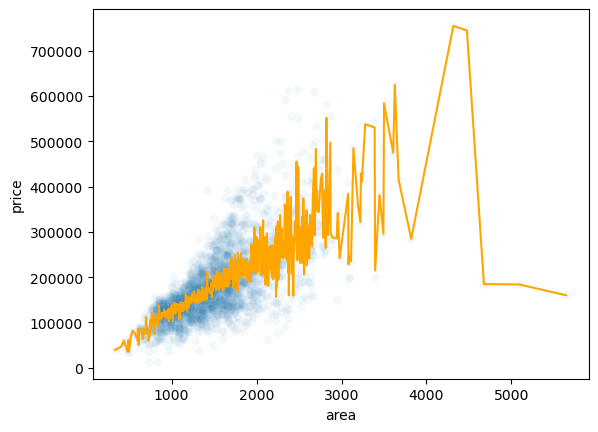

In [ ]:
y_hat, grid = lcls(x,y,h=2) # Overfit or underfit?

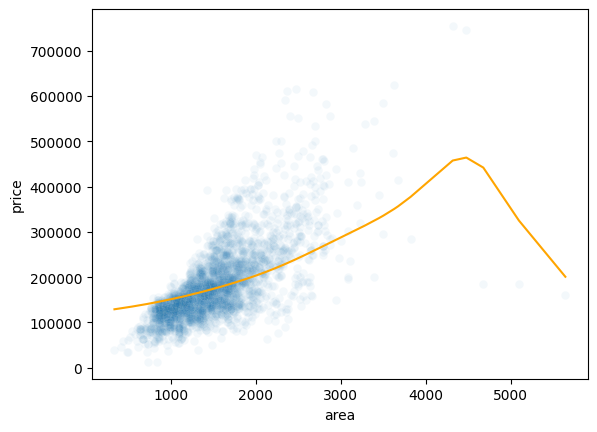

In [ ]:
y_hat, grid = lcls(x,y,h=500) # Overfit or underfit?

## Exercise:
We showed that the mean and median could be discovered by minimizing various kinds of loss functions; this is what machine learning is. For this context, consider choosing the prediction $\hat{y}(z)$ at $z$ to minimize the mean squared error:
$$
MSE(\hat{y}(z)) = \dfrac{1}{N} \sum_{i=1}^N \left\lbrace y_i - \hat{y}(z) \right\rbrace^2 \frac{1}{h}k\left(\frac{z-x_i}{h}\right)
$$
Show that the solution to this problem is the LCLS estimator.

## Exercise:
- Write a class that implements the Naradaya-Watson estimator, using the Silverman plug-in estimate for the conditioning variable $X$ as the bandwidth. Write a function that makes predictions for any value $z$.
- From the data, find two numeric variables of interest, implement the LCLS estimator, and plot your results.

# 3. Causality and Interpretation

## Conditional Expectation
- When we use a condition like $X=x$, we're restricting the space of possibilities and our estimates $\widehat{\mathbb{E}}[Y|X=x]$ better reflect available information and context
- As your education progresses, what you learn is how to model $\widehat{\mathbb{E}}[Y|X=x]$ in increasingly sophisticated ways (e.g. generalized linear models, random forest, neural network)
- This does not necessarily mean our estimates become more **precise**: We can have estimators that vary with the data, but become unreliable (e.g. overfitting, poor calibration, inconsistent/biased estiamtes)
- It also does not mean that an exogenous intervention that changes $X=x$ will change $Y$ in the same way that endogenous changes in $X$ do

## Conditioning $Y|X=x$ vs. $Y|\text{do}(X=x)$
- In examples above, you can see we can't interpret the condtional expectation as a causal relationship
- There is a field of **causal inference** that tries to understand when deliberate changes in one variable $X$ mean a shift in the distribution of $Y$
- Merely adding A/C or a fireplace won't change the value of a house like the numbers above (which were ludicrously large): Instead, the **kind of house that has A/C or fireplaces** has many characteristics that make it more expensive. That's the number we were getting.
- Judea Pearl has advocated for a distinction between condition $|X=x$ versus interventions where $\text{do}(X=x)$ corresponds to an exogenous change in the system
- There are many causal estimation strategies (difference-in-differences, instrumental variables, regression discontinuity design, propensity score matching, randomized controlled trials, etc.)
- Prediction and decision, when combined, can be very dangerous

## Example: Cancer Treatments
- Let's plot the ECDF for months of survival time (350 months is 29 years) for each of the treatments

In [ ]:
df = pd.read_csv('./data/metabric.csv', low_memory=False)
y = df['Overall Survival (Months)']

## Radio Therapy:

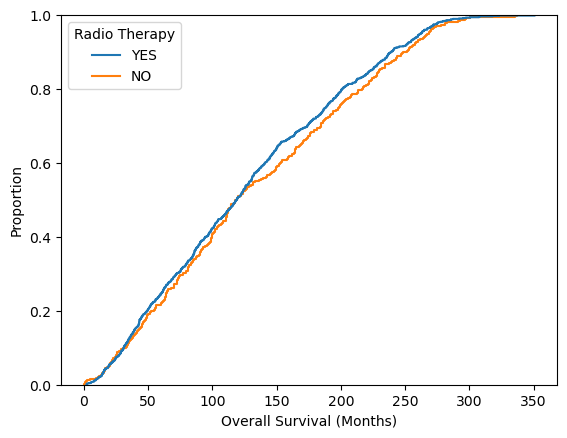

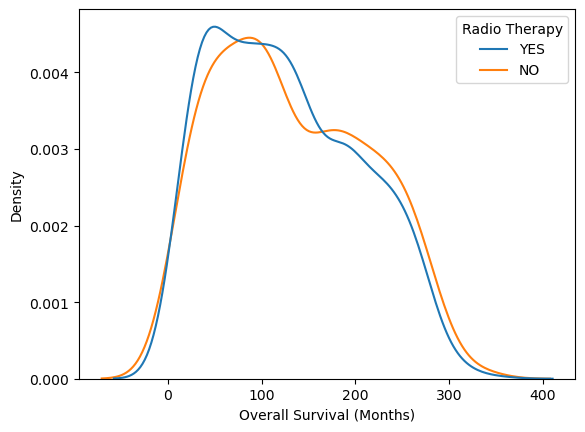

In [32]:
sns.ecdfplot( x= y, hue =df['Radio Therapy'] )
plt.show() 

sns.kdeplot( x= y, hue =df['Radio Therapy'], common_norm=False)
plt.show() 

## Chemo Therapy:

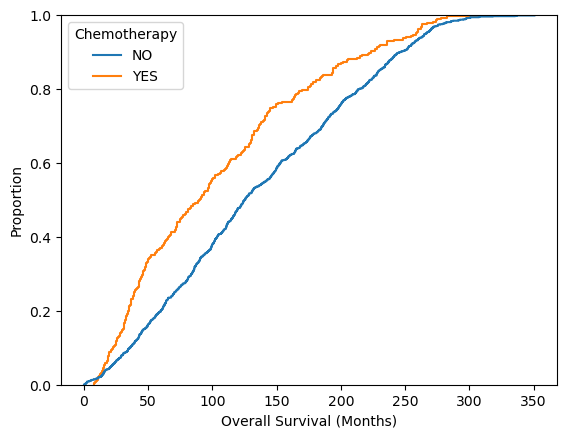

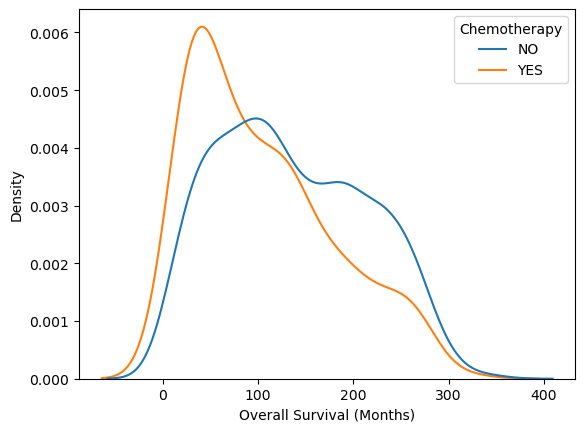

In [33]:
sns.ecdfplot( x= y, hue =df['Chemotherapy'] )
plt.show() 

sns.kdeplot( x= y, hue =df['Chemotherapy'], common_norm=False )
plt.show() 

## Hormone Therapy:

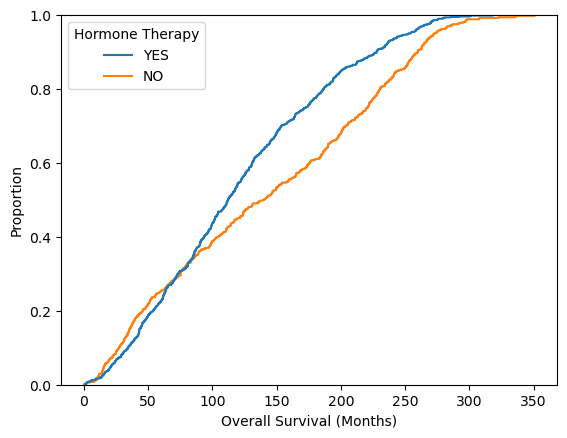

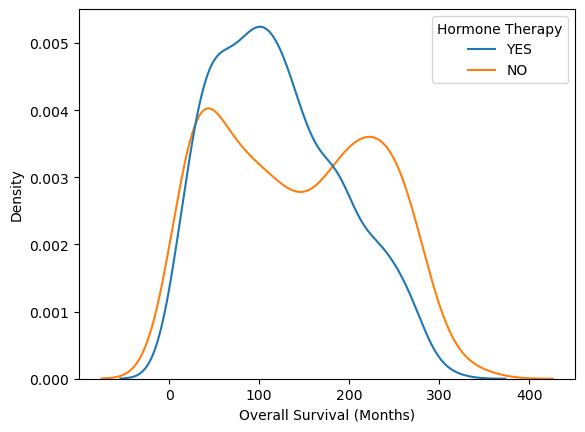

In [34]:
sns.ecdfplot( x= y, hue =df['Hormone Therapy'] )
plt.show() 

sns.kdeplot( x= y, hue =df['Hormone Therapy'], common_norm=False )
plt.show() 

- The naive interpretation is that radio therapy doesn't give very different outcomes, chemotherapy is much worse, and hormone therapy is ineffective or harmful.
- Is this a reasonably way to interpret the results? Why do patients who get more intensive treatment appear to be more likely to die earlier?
- How do we actually determine whether interventions are medically effective?
- This is the exact same issue as asserting that adding A/C will raise the price of a house by $80k, just in a different context
- This mistake of confusing causation with correlation is painfully common, and is getting worse as more clueless people analyze data

In [35]:
treatment = 'Radio Therapy'
df.loc[:, ['Type of Breast Surgery','Overall Survival (Months)']].groupby('Type of Breast Surgery').mean()

,Overall Survival (Months)
Type of Breast Surgery,
BREAST CONSERVING,138.826667
MASTECTOMY,121.917766


In [36]:
treatment = 'Radio Therapy'
df.loc[:, ['Type of Breast Surgery','Overall Survival (Months)',treatment]].groupby(['Type of Breast Surgery',treatment]).mean()

Overall Survival (Months)
Type of Breast Surgery Radio Therapy                           
BREAST CONSERVING      NO                            126.771154
                       YES                           140.036873
MASTECTOMY             NO                            133.946337
                       YES                           108.679801

In [37]:
pd.crosstab(df['Type of Breast Surgery'], df['Chemotherapy'],normalize='columns') # More aggressive procedures are correlated

Chemotherapy,NO,YES
Type of Breast Surgery,,
BREAST CONSERVING,0.447493,0.339161
MASTECTOMY,0.552507,0.660839


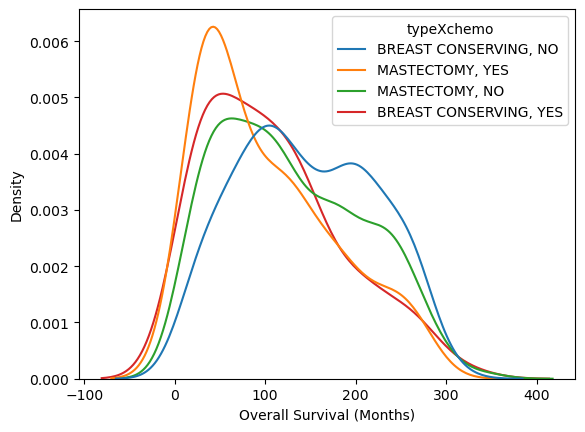

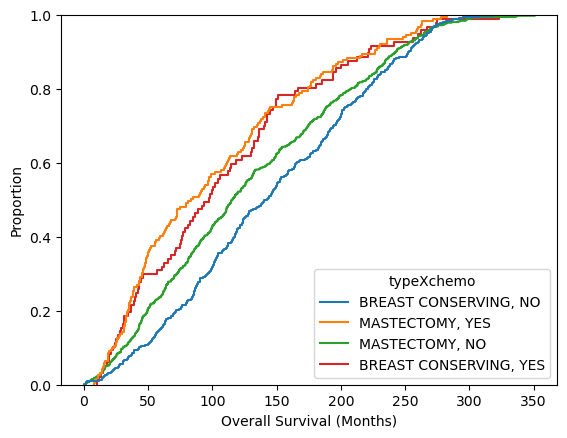

In [38]:
df['typeXchemo'] = df['Type of Breast Surgery'] + ', ' +df['Chemotherapy']
sns.kdeplot(x=df['Overall Survival (Months)'], hue = df['typeXchemo'], common_norm = False)
plt.show()
sns.ecdfplot(x=df['Overall Survival (Months)'], hue = df['typeXchemo'])
plt.show()

- Patterns reverse for radiotherapy when you condition on the type of surgery
- Mortality is essentially ranked by the aggressiveness of treatment: Doctors are (likely) using the appropriate tools to deal with the severity of the case
- **We are learning about the unobserved severity of the case by observing the intensity of treatment**
- Reasoning about how you ought to act by looking at data is extremely risky, and should be done with care
- We are not "done" with knowledge; data science does not replace Science

## Exercise: Omitted Variables Bias
- In any of the data sets, investigate the relationships between pairs of variables $(X,Y)$ with a scatterplot and CEF (for example, price on area)
- Is this relationship plausibly causal, or are there missing variables that might explain at least part of the relationship between your variables? These can be "conceptual" rather than "practical"; for example, 'talent' or 'grit' probably explain education outcomes, but are almost impossible to measure. We are asking whether there are hypothetical **threats to causal identification** of the effect of $X$ on $Y$.
- Explain how, regardless of the threat to causal identification, you can still use your model to predict $Y$ given $X$, as long as you don't intervene in the system to control the outcome

## Conclusion
- When you make predictions, you are conditioning on some feature/explanatory variable $X$, and providing an estimate of the values that $Y$ will likely or probably take. We typically call this $\mathbb{E}[Y|X=x]$, the conditional expectation of $Y$ given $X=x$
- What we've done here is typically called **non-parametric analytics**: We aren't using a linear model or a tree or a neural network, we're just looking at the raw patterns in the data between two variables $X$ and $Y$
- Regardless of how technical you become, these tools are outrageously useful for visualization, and grounding yourself in these fundamental ideas means you can reason more clearly about what you're doing and why